## Question 3

Design a feature selection algorithm to find the best features for classifying the Mnist dataset. Implement a bidirectional search algorithm using the provided objective function as the measure for your search algorithm.

Use the first 10000 samples of training set in the Mnist dataset for feature selection and training set for kNN approach. Use Euclidean distance to calculate Inter-class.

The objective function should be based on this equestion:

### J = Inter Class distance

In [15]:
import gzip
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

image_size = 28
training_samples = 60000

# Importing Train Data
f_train = gzip.open('train-images-idx3-ubyte.gz','r')
f_train.read(16)
buf = f_train.read(image_size * image_size * training_samples)
train_data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
# train_data = data.reshape(num_images, image_size, image_size)
train_data = train_data.reshape(training_samples, image_size* image_size)


# Importing Train Labels
f_train_label = gzip.open('train-labels-idx1-ubyte.gz','r')
f_train_label.read(8)
buf = f_train_label.read(training_samples)
train_labels = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)


# Importing Test Data
testing_images = 10000
f_test = gzip.open('t10k-images-idx3-ubyte.gz','r')
f_test.read(16)
buf = f_test.read(image_size * image_size * testing_images)
test_data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
test_data = test_data.reshape(testing_images, image_size * image_size)

# Importing Test Labels
f_test_label = gzip.open('t10k-labels-idx1-ubyte.gz','r')
f_test_label.read(8)
buf = f_test_label.read(testing_images)
test_labels = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)


train_data = train_data[0:10000]
train_labels = train_labels[0:10000]

In [2]:
from sklearn.neighbors import KNeighborsClassifier
def apply_knn(train_data, train_labels, k):
    
    train_d =train_data[:8000]
    train_l =train_labels[:8000]
    
    test_d = train_data[8001:]
    test_l =train_labels[8001:]
    
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(train_d,train_l)
    
    correct = 0
    for i in range(len(test_d)):
        if model.predict([test_d[i]]) == test_l[i]: correct+=1
    
    return correct/len(test_d)

a) Select the set of {10, 50, 150, 392} features based on the implemented feature selection approach and report the accuracy on the test set of MNIST based on kNN with k = 3. Note: you can take advantage of data structure tricks to speed up the efficiency of kNN algorithm.

In [24]:
my_train_data = train_data
new_train_data = None

for _ in range(10):
 
    # SFS
    main_mean = np.mean(my_train_data, axis=0)
    mean_i = []
    for i in np.unique(train_labels):
        indices_of_i = np.where(train_labels == i)[0]
        c_i = np.take(my_train_data, indices_of_i, axis=0)
        mean_i.append(np.mean(c_i, axis=0))    

    total_no_of_features= len(mean_i[0])
    J = np.zeros(total_no_of_features)

    for i in range(total_no_of_features):
        for mean in mean_i:
            distance = euclidean(main_mean[i],mean[i])
            J[i]+= distance
    
    print(np.argmax(J))
    if new_train_data is None:
        new_train_data=my_train_data[:,np.argmax(J)]
    else:  
        new_train_data = np.c_[new_train_data, my_train_data[:,np.argmax(J)]]
    my_train_data = np.delete(my_train_data,np.argmax(J), 1)

    # SBS
    main_mean = np.mean(my_train_data, axis=0)
    mean_i = []
    for i in np.unique(train_labels):
        indices_of_i = np.where(train_labels == i)[0]
        c_i = np.take(my_train_data, indices_of_i, axis=0)
        mean_i.append(np.mean(c_i, axis=0))    

    total_no_of_features= len(mean_i[0])
    J = np.zeros(total_no_of_features)

    for i in range(total_no_of_features):
        for mean in mean_i:
            distance = euclidean(main_mean[i],mean[i])
            J[i]+= distance
    my_train_data = np.delete(my_train_data,np.argmin(J), 1)

print(new_train_data.shape)

461
377
592
347
482
587
533
504
477
526
(10000, 10)


In [41]:
my_train_data = train_data
new_train_data = None


deleted_j_max_indices = []
deleted_j_min_indices = []
for _ in range(10):
    
    # SFS
    main_mean = np.mean(my_train_data, axis=0)
    mean_i = []
    for i in np.unique(train_labels):
        indices_of_i = np.where(train_labels == i)[0]
        c_i = np.take(my_train_data, indices_of_i, axis=0)
        mean_i.append(np.mean(c_i, axis=0))    

    J_max = 0
    j_max_index = 0
    for i in range(784):
        if i not in deleted_j_max_indices and i not in deleted_j_min_indices:
            distance = 0
            for mean in mean_i:
                distance += euclidean(main_mean[i],mean[i])
            if distance >= J_max:
                J_max = distance
                j_max_index = i
   
    deleted_j_max_indices.append(j_max_index)
    
    if new_train_data is None:
        new_train_data=my_train_data[:,j_max_index]
    else:  
        new_train_data = np.c_[new_train_data, my_train_data[:,j_max_index]]

    
    # SBS
    main_mean = np.mean(my_train_data, axis=0)
    mean_i = []
    for i in np.unique(train_labels):
        indices_of_i = np.where(train_labels == i)[0]
        c_i = np.take(my_train_data, indices_of_i, axis=0)
        mean_i.append(np.mean(c_i, axis=0))  
        
    J_min = J_max
    j_min_index = 0
    for i in range(784):
        if i not in deleted_j_max_indices and i not in deleted_j_min_indices:
            distance = 0
            for mean in mean_i:
                distance += euclidean(main_mean[i],mean[i])
            if distance <= J_min:
                J_min = distance
                j_min_index = i
    
    deleted_j_min_indices.append(j_min_index)

print(new_train_data.shape)

(10000, 10)


In [40]:
apply_knn(new_train_data,train_labels, 3)

0.5812906453226613

In [56]:
deleted_j_max_indices

[461, 378, 596, 350, 489, 597, 543, 515, 488, 541]

In [17]:
new_train_data_10 = new_train_data[:,:10]
new_train_data_50 = new_train_data[:,:50]
new_train_data_150 = new_train_data[:,:150]
new_train_data_392 = new_train_data

accuracies = []
accuracies.append(apply_knn(new_train_data_10,train_labels, 3))
accuracies.append(apply_knn(new_train_data_50,train_labels, 3))
accuracies.append(apply_knn(new_train_data_150,train_labels, 3))
accuracies.append(apply_knn(new_train_data_392,train_labels, 3))
print(accuracies)

[0.5812906453226613, 0.8164082041020511, 0.9134567283641821, 0.9364682341170585]


b) Visualize the selected features for each set in {10, 50, 150, 392} by a zero 2-D plane where the selected features are pixels set to a value of 1. Compare the 4 different planes.

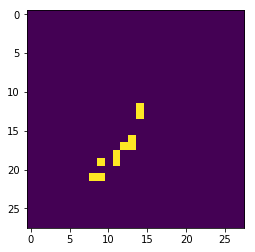

In [82]:
data = np.zeros(784)
for val in deleted_j_max_indices:
    data[val] = 1.0
data = data.reshape((28, 28))
plt.imshow(data);
plt.show()

c) Apply LDA on the dataset and report the accuracy based on kNN with k =3. Compare the achieved accuracy by the reported accuracies in part (a). Note: you need to implement LDA method by yourself.

In [309]:
my_train_data = train_data

overall_mean = np.mean(my_train_data, axis=0)
means = []
for i in np.unique(train_labels):
    indices_of_i = np.where(train_labels == i)[0]
    c_i = np.take(my_train_data, indices_of_i, axis=0)
    mean_i.append(np.mean(c_i, axis=0))   

S_W = np.zeros((len(my_train_data),len(my_train_data[0])))


for m in means:
    
S_W

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [307]:
def estimate_params(data):
        # group data by label column
#         grouped = data.groupby(self.data.ix[:,self.labelcol])

        # calculate means for each class
#         means = {}
#         for c in self.classes:
#             means[c] = np.array(self.drop_col(self.classwise[c], self.labelcol).mean(axis = 0))

        # calculate the overall mean of all the data
        overall_mean = np.array(self.drop_col(data, self.labelcol).mean(axis = 0))

        
        overall_mean = np.mean(my_train_data, axis=0)
        means = []
        for i in np.unique(train_labels):
            indices_of_i = np.where(train_labels == i)[0]
            c_i = np.take(my_train_data, indices_of_i, axis=0)
            mean_i.append(np.mean(c_i, axis=0))    

        
        # calculate between class covariance matrix
        # S_B = \sigma{N_i (m_i - m) (m_i - m).T}
        S_B = np.zeros((data.shape[1] - 1, data.shape[1] - 1))
        for c in means.keys():
            S_B += np.multiply(len(self.classwise[c])
                               , np.outer((means[c] - overall_mean)
                                          , (means[c] - overall_mean)))

        # calculate within class covariance matrix
        # S_W = \sigma{S_i}
        # S_i = \sigma{(x - m_i) (x - m_i).T}
        S_W = np.zeros(S_B.shape) 
        for c in self.classes: 
            tmp = np.subtract(self.drop_col(self.classwise[c], self.labelcol).T, np.expand_dims(means[c], axis=1))
            S_W = np.add(np.dot(tmp, tmp.T), S_W)

        # objective : find eigenvalue, eigenvector pairs for inv(S_W).S_B
        mat = np.dot(np.linalg.pinv(S_W), S_B)
        eigvals, eigvecs = np.linalg.eig(mat)
        eiglist = [(eigvals[i], eigvecs[:, i]) for i in range(len(eigvals))]

        # sort the eigvals in decreasing order
        eiglist = sorted(eiglist, key = lambda x : x[0], reverse = True)

        # take the first num_dims eigvectors
        w = np.array([eiglist[i][1] for i in range(self.num_dims)])

        self.w = w
        self.means = means
        print(w.shape)
        return
    
print(train_data.shape)
estimate_params(train_data)

(10000, 784)


AttributeError: 'list' object has no attribute 'keys'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.model_selection import train_test_split
style.use('fivethirtyeight')
from sklearn.neighbors import KNeighborsClassifier
# 0. Load in the data and split the descriptive and the target feature
df = pd.read_csv('data/Wine.txt',sep=',',names=['target','Alcohol','Malic_acid','Ash','Akcakinity','Magnesium','Total_pheonols','Flavanoids','Nonflavanoids','Proanthocyanins','Color_intensity','Hue','OD280','Proline'])
X = df.iloc[:,1:].copy()
target = df['target'].copy()
X_train, X_test, y_train, y_test = train_test_split(X,target,test_size=0.3,random_state=0) 
# 1. Standardize the data
for col in X_train.columns:
    X_train[col] = StandardScaler().fit_transform(X_train[col].values.reshape(-1,1))
# 2. Compute the mean vector mu and the mean vector per class mu_k
mu = np.mean(X_train,axis=0).values.reshape(13,1) # Mean vector mu --> Since the data has been standardized, the data means are zero 
mu_k = []
for i,orchid in enumerate(np.unique(df['target'])):
    mu_k.append(np.mean(X_train.where(df['target']==orchid),axis=0))
mu_k = np.array(mu_k).T
# 3. Compute the Scatter within and Scatter between matrices
data_SW = []
Nc = []
for i,orchid in enumerate(np.unique(df['target'])):
    a = np.array(X_train.where(df['target']==orchid).dropna().values-mu_k[:,i].reshape(1,13))
    data_SW.append(np.dot(a.T,a))
    Nc.append(np.sum(df['target']==orchid))
SW = np.sum(data_SW,axis=0)
SB = np.dot(Nc*np.array(mu_k-mu),np.array(mu_k-mu).T)
   
# 4. Compute the Eigenvalues and Eigenvectors of SW^-1 SB
eigval, eigvec = np.linalg.eig(np.dot(np.linalg.inv(SW),SB))
    
# 5. Select the two largest eigenvalues 
eigen_pairs = [[np.abs(eigval[i]),eigvec[:,i]] for i in range(len(eigval))]
eigen_pairs = sorted(eigen_pairs,key=lambda k: k[0],reverse=True)
w = np.hstack((eigen_pairs[0][1][:,np.newaxis].real,eigen_pairs[1][1][:,np.newaxis].real)) # Select two largest
# 6. Transform the data with Y=X*w
Y = X_train.dot(w)
# Plot the data
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)
ax0.set_xlim(-3,3)
ax0.set_ylim(-4,3)
for l,c,m in zip(np.unique(y_train),['r','g','b'],['s','x','o']):
    ax0.scatter(Y[0][y_train==l],
                Y[1][y_train==l],
               c=c, marker=m, label=l,edgecolors='black')
ax0.legend(loc='upper right')
# Plot the voroni spaces
means = []
for m,target in zip(['s','x','o'],np.unique(y_train)):
    means.append(np.mean(Y[y_train==target],axis=0))
    ax0.scatter(np.mean(Y[y_train==target],axis=0)[0],np.mean(Y[y_train==target],axis=0)[1],marker=m,c='black',s=100)
   
mesh_x, mesh_y = np.meshgrid(np.linspace(-3,3),np.linspace(-4,3)) 
mesh = []
for i in range(len(mesh_x)):
    for j in range(len(mesh_x[0])):
        date = [mesh_x[i][j],mesh_y[i][j]]
        mesh.append((mesh_x[i][j],mesh_y[i][j]))
NN = KNeighborsClassifier(n_neighbors=1)
NN.fit(means,['r','g','b'])        
predictions = NN.predict(np.array(mesh))
ax0.scatter(np.array(mesh)[:,0],np.array(mesh)[:,1],color=predictions,alpha=0.3)
plt.show()
    

In [222]:
apply_knn(train_data,train_labels)

0.9349674837418709


[[1], [2], [3], [4]]